[[Python] Keras-RLで簡単に強化学習(DQN)を試す](http://qiita.com/inoory/items/e63ade6f21766c7c2393)を参考に、エージェントを作成する。FXの自動取引を行い、利益を出すのが目標。

In [ ]:
import matplotlib as mpl
mpl.use('tkagg')
import numpy as np
import pandas as pd
import talib
from logging import getLogger, DEBUG, INFO, WARN
import os

from hist_data import HistData
from fx_trade import FXTrade
from deep_fx import DeepFX
from debug_tools import DebugTools

Using TensorFlow backend.


In [ ]:
IS_SEND_LOG_TO_STACKDRIVER = True
if IS_SEND_LOG_TO_STACKDRIVER:
    import logging
    import google.cloud.logging
    from google.cloud.logging.handlers import CloudLoggingHandler
    jupyter_logger = logging.getLogger()
    jupyter_logger.setLevel(logging.WARN)
    client = google.cloud.logging.Client \
        .from_service_account_json(os.environ.get('GOOGLE_SERVICE_ACCOUNT_JSON_PATH'))
    client.setup_logging(log_level=logging.INFO)
    handler = CloudLoggingHandler(client, name='deepfx')
    logger = logging.getLogger()
else:
    from logging import StreamHandler
    logger = getLogger(__name__)
    handler = StreamHandler()
    logger.setLevel(INFO)
logger.addHandler(handler)
logger.info('DeepFX Started: %s' % DebugTools.now_str())

DeepFX Started: 17/11/06 01:15:46


In [ ]:
#import imp
#import sys
#del(hist_data)
#from hist_data import HistData
#del(hist_data)
#imp.reload(hist_data)
#imp.reload(sys.modules[hist_data.__module__])
hd = HistData(csv_path = 'historical_data/DAT_ASCII_USDJPY_M1_201710_m5.csv',
                     begin_date='2017-10-02T00:00:00',
                     end_date='2017-10-02T23:59:59')
                     #end_date='2017-10-09T23:59:59')

header is included


In [ ]:
hd.data()
#len(hist_data.data())

,Open,High,Low,Close,Volume
Date,,,,,
2017-10-02 00:00:00,112.808,112.833,112.805,112.833,0
2017-10-02 00:05:00,112.833,112.834,112.784,112.793,0
2017-10-02 00:10:00,112.793,112.821,112.788,112.812,0
2017-10-02 00:15:00,112.812,112.812,112.790,112.794,0
2017-10-02 00:20:00,112.801,112.805,112.787,112.795,0
2017-10-02 00:25:00,112.795,112.832,112.794,112.826,0
2017-10-02 00:30:00,112.826,112.834,112.820,112.827,0
2017-10-02 00:35:00,112.825,112.851,112.819,112.832,0
2017-10-02 00:40:00,112.836,112.851,112.827,112.841,0


In [ ]:
env = FXTrade(1000000, 0.08, hd, logger=logger)
#env = FXTrade(1000000, 0.08, h, logger=logger)
prepared_model_filename = None #'Keras-RL_DQN_FX_model_meanq1.440944e+06_episode00003.h5'
dfx = DeepFX(env, prepared_model_filename=prepared_model_filename, steps = 100000, logger=logger)

In [ ]:
is_to_train = True
if is_to_train:
    dfx.train(is_for_time_measurement=True)
else:
    dfx.test(1, [EpisodeLogger()])

None
17/11/06 01:15:46
Training for 100000 steps ...
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Training for 100000 steps ...
Training for 100000 steps ...
========== Model Saver output ==============
mean_q value: 0.000000e+00
Step 00001: model improved
  from 0.000000e+00
    to 0.000000e+00, saving model to ./models/Keras-RL_DQN_FX_model_meanq0.000000e+00_episode00000
Save model to ./models/Keras-RL_DQN_FX_model_meanq0.000000e+00_episode00000 has done.

     1/100000: episode: 1, duration: 0.070s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
     2/100000: episode: 2, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_re


max mean_q value: 0.000000e+00
========== /Model Saver output =============
     1/100000: episode: 1, duration: 0.068s, episode steps: 1, steps per second: 15, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
     1/100000: episode: 1, duration: 0.181s, episode steps: 1, steps per second: 6, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
     2/100000: episode: 2, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
     2/10

今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
     4/100000: episode: 4, duration: 0.061s, episode steps: 1, steps per second: 16, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
     5/100000: episode: 5, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observati

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
     4/100000: episode: 4, duration: 0.060s, episode steps: 1, steps per second: 17, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
     4/100000: episode: 4, duration: 0.067s, episode steps: 1, steps per second: 15, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
     5/100000: episode: 5, duration: 0.061s, episode steps: 1, steps per second: 16, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000,

     7/100000: episode: 7, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
     8/100000: episode: 8, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_re

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
     7/100000: episode: 7, duration: 0.063s, episode steps: 1, steps per second: 16, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
     7/100000: episode: 7, duration: 0.069s, episode steps: 1, steps per second: 15, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
     8/100000: episode: 8, duration: 0.058s, episode steps: 1, steps per second: 17, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000,

now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    11/100000: episode: 11, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    12/100000: episode: 12, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    11/100000: episode: 11, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    11/100000: episode: 11, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    12/100000: episode: 12, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    15/100000: episode: 15, duration: 0.068s, episode steps: 1, steps per second: 15, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    16/100000: episode: 16, duration: 0.074s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self.

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    15/100000: episode: 15, duration: 0.068s, episode steps: 1, steps per second: 15, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    15/100000: episode: 15, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    16/100000: episode: 16, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115207.739151
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
    19/100000: episode: 18, duration: 0.090s, episode steps: 2, steps per second: 22, episode reward: 884792.261, mean reward: 442396.130 [-115207.739, 1000000.000], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    20/100000: episode: 19, duration: 0.047s, episode steps: 1, steps per second: 21

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    19/100000: episode: 18, duration: 0.089s, episode steps: 2, steps per second: 23, episode reward: 884792.261, mean reward: 442396.130 [-115207.739, 1000000.000], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: --, mean_q: --
    19/100000: episode: 18, duration: 0.093s, episode steps: 2, steps per second: 21, episode reward: 884792.261, mean reward: 442396.130 [-115207.739, 1000000.000], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    20/100000: episode: 19, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    23/100000: episode: 22, duration: 0.070s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000000.000000
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115207.739151
now_date

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    23/100000: episode: 22, duration: 0.069s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    23/100000: episode: 22, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    25/100000: episode: 23, duration: 0.068s, episode steps: 2, steps per second: 29, episode reward: 884792.261, mean reward: 442396.130 [-115207.739, 1000000.000], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000

positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    28/100000: episode: 26, duration: 0.049s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    29/100000: episode: 27, duration: 0.043s, episode steps: 1, st

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    28/100000: episode: 26, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    28/100000: episode: 26, duration: 0.051s, episode steps: 1, steps per second: 19, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    29/100000: episode: 27, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    33/100000: episode: 30, duration: 0.055s, episode steps: 1, steps per second: 18, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    34/100000: episode: 31, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    33/100000: episode: 30, duration: 0.054s, episode steps: 1, steps per second: 18, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    33/100000: episode: 30, duration: 0.059s, episode steps: 1, steps per second: 17, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    34/100000: episode: 31, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

    37/100000: episode: 34, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    38/100000: episode: 35, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    37/100000: episode: 34, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    37/100000: episode: 34, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    38/100000: episode: 35, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    41/100000: episode: 38, duration: 0.054s, episode steps: 1, steps per second: 18, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    42/100000: episode: 39, duration: 0

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    41/100000: episode: 38, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    41/100000: episode: 38, duration: 0.056s, episode steps: 1, steps per second: 18, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    42/100000: episode: 39, duration: 0.057s, episode steps: 1, steps per second: 17, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    45/100000: episode: 42, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    46/100000: episode: 43, duration: 0.080s, episode steps: 1, steps per second: 12, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self.

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    45/100000: episode: 42, duration: 0.049s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    45/100000: episode: 42, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    46/100000: episode: 43, duration: 0.079s, episode steps: 1, steps per second: 13, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    48/100000: episode: 45, duration: 0.074s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    49/

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    48/100000: episode: 45, duration: 0.073s, episode steps: 1, steps per second: 14, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    48/100000: episode: 45, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    49/100000: episode: 46, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    52/100000: episode: 49, duration: 0.050s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    53/100000: episode: 50, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self.

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    52/100000: episode: 49, duration: 0.049s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    52/100000: episode: 49, duration: 0.053s, episode steps: 1, steps per second: 19, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    53/100000: episode: 50, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    57/100000: episode: 54, duration: 0.043s, episode steps: 1, steps per second: 24, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    57/100000: episode: 54, duration: 0.042s, episode steps: 1, steps per second: 24, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    57/100000: episode: 54, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    58/100000: episode: 55, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

    61/100000: episode: 58, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    62/100000: episode: 59, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    61/100000: episode: 58, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    61/100000: episode: 58, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    62/100000: episode: 59, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

reward: -115207.739151
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
    66/100000: episode: 62, duration: 0.070s, episode steps: 2, steps per second: 29, episode reward: 884792.261, mean reward: 442396.130 [-115207.739, 1000000.000], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    67/100000: episode: 63, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: -115598.714, mean rewa

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    66/100000: episode: 62, duration: 0.069s, episode steps: 2, steps per second: 29, episode reward: 884792.261, mean reward: 442396.130 [-115207.739, 1000000.000], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: --, mean_q: --
    66/100000: episode: 62, duration: 0.072s, episode steps: 2, steps per second: 28, episode reward: 884792.261, mean reward: 442396.130 [-115207.739, 1000000.000], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    67/100000: episode: 63, duration: 0.038s, episode steps: 1, steps per second: 26, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    71/100000: episode: 67, duration: 0.044s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    72/

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    71/100000: episode: 67, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    71/100000: episode: 67, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    72/100000: episode: 68, duration: 0.039s, episode steps: 1, steps per second: 25, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
_step 000003 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115009.769405
now_datetime: 2017-10-02 00:15:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000003 [2017-10-02 00:15:00]
   after: 000004 [2017-10-02 00:20:00]
_step ENDED
    78/100000: episode: 71, duration: 0.110s, episode steps: 4, steps per second: 36, episode reward: 5116401.947, mean reward: 1279100.487 [-115009.769, 2115603.227], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000004.513320
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDE

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    78/100000: episode: 71, duration: 0.108s, episode steps: 4, steps per second: 37, episode reward: 5116401.947, mean reward: 1279100.487 [-115009.769, 2115603.227], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: --, mean_q: --
    78/100000: episode: 71, duration: 0.114s, episode steps: 4, steps per second: 35, episode reward: 5116401.947, mean reward: 1279100.487 [-115009.769, 2115603.227], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    80/100000: episode: 72, duration: 0.073s, episode steps: 2, steps per second: 27, episode reward: 884796.774, mean reward: 442398.387 [-115207.739, 1000004.513], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000

2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    84/100000: episode: 74, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    85/100000: episode: 75, duration: 0.047s, episode steps: 1, steps per second: 21, episo

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    84/100000: episode: 74, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    84/100000: episode: 74, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    85/100000: episode: 75, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    89/100000: episode: 79, duration: 0.044s, episode steps: 1, steps per second: 23, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    90/

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    89/100000: episode: 79, duration: 0.043s, episode steps: 1, steps per second: 23, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    89/100000: episode: 79, duration: 0.048s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    90/100000: episode: 80, duration: 0.040s, episode steps: 1, steps per second: 25, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    94/100000: episode: 84, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115598.714111
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
    95/100000: epi

========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    94/100000: episode: 84, duration: 0.046s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
    94/100000: episode: 84, duration: 0.047s, episode steps: 1, steps per second: 21, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: --, mean_q: --
========== Model Saver output ==============
mean_q value: 0.000000e+00
========== /Model Saver output =============
    95/100000: episode: 85, duration: 0.045s, episode steps: 1, steps per second: 22, episode reward: -115598.714, mean reward: -115598.714 [-115598.714, -115598.714], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.0

現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 999606.881973
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115605.370498
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   102/100000: episode: 87, duration: 0.530s, episode steps: 2, steps per second: 4, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 378058375168.000000, mean_q: 56.969555
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 999606.88

========== Model Saver output ==============
mean_q value: 5.696955e+01
Step 00102: model improved
  from 0.000000e+00
    to 5.696955e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq5.696955e+01_episode00086
Save model to ./models/Keras-RL_DQN_FX_model_meanq5.696955e+01_episode00086 has done.
max mean_q value: 5.696955e+01
========== /Model Saver output =============
   102/100000: episode: 87, duration: 0.528s, episode steps: 2, steps per second: 4, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 378058375168.000000, mean_q: 56.969555
   102/100000: episode: 87, duration: 0.534s, episode steps: 2, steps per second: 4, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 378058375168.000000, mean_q: 56.969555
========== Model Saver output ==============
m

   106/100000: episode: 89, duration: 0.102s, episode steps: 2, steps per second: 20, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 165227921408.000000, mean_q: 57.396797
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 999606.881973
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115605.370498
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   108/100000: episode: 90, duration: 0.098s, episode steps: 2, steps per second: 20, episode rewar

========== Model Saver output ==============
mean_q value: 5.739680e+01
Step 00106: model improved
  from 5.729490e+01
    to 5.739680e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq5.739680e+01_episode00088
Save model to ./models/Keras-RL_DQN_FX_model_meanq5.739680e+01_episode00088 has done.
max mean_q value: 5.739680e+01
========== /Model Saver output =============
   106/100000: episode: 89, duration: 0.100s, episode steps: 2, steps per second: 20, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 165227921408.000000, mean_q: 57.396797
   106/100000: episode: 89, duration: 0.105s, episode steps: 2, steps per second: 19, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 165227921408.000000, mean_q: 57.396797
========== Model Saver output ==============

今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   110/100000: episode: 91, duration: 0.122s, episode steps: 2, steps per second: 16, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 153453592576.000000, mean_q: 57.638672
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 999606.881973
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115605.370498
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 

========== Model Saver output ==============
mean_q value: 5.763867e+01
Step 00110: model improved
  from 5.756703e+01
    to 5.763867e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq5.763867e+01_episode00090
Save model to ./models/Keras-RL_DQN_FX_model_meanq5.763867e+01_episode00090 has done.
max mean_q value: 5.763867e+01
========== /Model Saver output =============
   110/100000: episode: 91, duration: 0.120s, episode steps: 2, steps per second: 17, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 153453592576.000000, mean_q: 57.638672
   110/100000: episode: 91, duration: 0.126s, episode steps: 2, steps per second: 16, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 153453592576.000000, mean_q: 57.638672
========== Model Saver output ==============

_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115605.370498
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   114/100000: episode: 93, duration: 0.112s, episode steps: 2, steps per second: 18, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 227200679936.000000, mean_q: 57.909691
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 999606.881973
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115605.370498
now

========== Model Saver output ==============
mean_q value: 5.790969e+01
Step 00114: model improved
  from 5.775286e+01
    to 5.790969e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq5.790969e+01_episode00092
Save model to ./models/Keras-RL_DQN_FX_model_meanq5.790969e+01_episode00092 has done.
max mean_q value: 5.790969e+01
========== /Model Saver output =============
   114/100000: episode: 93, duration: 0.111s, episode steps: 2, steps per second: 18, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 227200679936.000000, mean_q: 57.909691
   114/100000: episode: 93, duration: 0.116s, episode steps: 2, steps per second: 17, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 227200679936.000000, mean_q: 57.909691
========== Model Saver output ==============

_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115605.370498
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   118/100000: episode: 95, duration: 0.120s, episode steps: 2, steps per second: 17, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 130337521664.000000, mean_q: 58.178497
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 999606.881973
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115605.370498
now

========== Model Saver output ==============
mean_q value: 5.817850e+01
Step 00118: model improved
  from 5.805007e+01
    to 5.817850e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq5.817850e+01_episode00094
Save model to ./models/Keras-RL_DQN_FX_model_meanq5.817850e+01_episode00094 has done.
max mean_q value: 5.817850e+01
========== /Model Saver output =============
   118/100000: episode: 95, duration: 0.117s, episode steps: 2, steps per second: 17, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 130337521664.000000, mean_q: 58.178497
   118/100000: episode: 95, duration: 0.123s, episode steps: 2, steps per second: 16, episode reward: 884001.511, mean reward: 442000.756 [-115605.370, 999606.882], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 130337521664.000000, mean_q: 58.178497
========== Model Saver output ==============

positions_buy_or_sell: -1
2017-10-02 00:00:00 112.833000
reward: 3230804.310195
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
positions_buy_or_sell: 1
reward: 3230808.823515
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 2115415.370859
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
_step 000003 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 1000195.826679
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000003 [2017-10-02 00:15:00]
   after: 000004 [2017-10-02 00:20:00]
_step ENDED
_step 000004 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115031.235690
now_datetime: 2017-10-02 00:20:00
len(self.hist_data.data()) - 1: 287
今注目している日時

========== Model Saver output ==============
mean_q value: 5.868053e+01
Step 00125: model improved
  from 5.841882e+01
    to 5.868053e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq5.868053e+01_episode00096
Save model to ./models/Keras-RL_DQN_FX_model_meanq5.868053e+01_episode00096 has done.
max mean_q value: 5.868053e+01
========== /Model Saver output =============
   125/100000: episode: 97, duration: 0.194s, episode steps: 5, steps per second: 26, episode reward: 9462193.096, mean reward: 1892438.619 [-115031.236, 3230808.824], mean action: 1.600 [0.000, 2.000], mean observation: 57.902 [1.000, 112.826], loss: 269813334016.000000, mean_q: 58.680531
   125/100000: episode: 97, duration: 0.199s, episode steps: 5, steps per second: 25, episode reward: 9462193.096, mean reward: 1892438.619 [-115031.236, 3230808.824], mean action: 1.600 [0.000, 2.000], mean observation: 57.902 [1.000, 112.826], loss: 269813334016.000000, mean_q: 58.680531
========== Model Saver output ========

reward: 2115210.109404
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 999997.856933
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115391.308829
now_datetime: 2017-10-02 00:10:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
   131/100000: episode: 99, duration: 0.148s, episode steps: 3, steps per second: 20, episode reward: 2999816.658, mean reward: 999938.886 [-115391.309, 2115210.109], mean action: 2.000 [2.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 225851392000.000000, mean_q: 59.201340
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:0

========== Model Saver output ==============
mean_q value: 5.920134e+01
Step 00131: model improved
  from 5.894628e+01
    to 5.920134e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq5.920134e+01_episode00098
Save model to ./models/Keras-RL_DQN_FX_model_meanq5.920134e+01_episode00098 has done.
max mean_q value: 5.920134e+01
========== /Model Saver output =============
   131/100000: episode: 99, duration: 0.144s, episode steps: 3, steps per second: 21, episode reward: 2999816.658, mean reward: 999938.886 [-115391.309, 2115210.109], mean action: 2.000 [2.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 225851392000.000000, mean_q: 59.201340
   131/100000: episode: 99, duration: 0.155s, episode steps: 3, steps per second: 19, episode reward: 2999816.658, mean reward: 999938.886 [-115391.309, 2115210.109], mean action: 2.000 [2.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 225851392000.000000, mean_q: 59.201340
========== Model Saver output ==========

現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 2115210.109404
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 999997.856933
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115391.308829
now_datetime: 2017-10-02 00:10:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
   137/100000: episode: 101, duration: 0.132s, episode steps: 3, steps per second: 23, episode reward: 2999816.658, mean reward: 999938.886 [-115391.309, 2115210.109], mean action: 2.000 [2.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 179395051520.00000

========== Model Saver output ==============
mean_q value: 6.006925e+01
Step 00137: model improved
  from 5.957710e+01
    to 6.006925e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.006925e+01_episode00100
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.006925e+01_episode00100 has done.
max mean_q value: 6.006925e+01
========== /Model Saver output =============
   137/100000: episode: 101, duration: 0.130s, episode steps: 3, steps per second: 23, episode reward: 2999816.658, mean reward: 999938.886 [-115391.309, 2115210.109], mean action: 2.000 [2.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 179395051520.000000, mean_q: 60.069248
   137/100000: episode: 101, duration: 0.134s, episode steps: 3, steps per second: 22, episode reward: 2999816.658, mean reward: 999938.886 [-115391.309, 2115210.109], mean action: 2.000 [2.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 179395051520.000000, mean_q: 60.069248


   142/100000: episode: 102, duration: 0.210s, episode steps: 5, steps per second: 24, episode reward: 8345016.943, mean reward: 1669003.389 [-115426.724, 3230413.335], mean action: 1.800 [1.000, 2.000], mean observation: 57.902 [1.000, 112.826], loss: 417008254976.000000, mean_q: 60.570385
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 2115210.109404
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 999997.856933
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115391.308829
now_datetime: 2017-10-02 00:10:00
len(self.hist_data.data()) - 1: 287

========== Model Saver output ==============
mean_q value: 6.057038e+01
Step 00142: model improved
  from 6.006925e+01
    to 6.057038e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.057038e+01_episode00101
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.057038e+01_episode00101 has done.
max mean_q value: 6.057038e+01
========== /Model Saver output =============
   142/100000: episode: 102, duration: 0.208s, episode steps: 5, steps per second: 24, episode reward: 8345016.943, mean reward: 1669003.389 [-115426.724, 3230413.335], mean action: 1.800 [1.000, 2.000], mean observation: 57.902 [1.000, 112.826], loss: 417008254976.000000, mean_q: 60.570385
   142/100000: episode: 102, duration: 0.213s, episode steps: 5, steps per second: 23, episode reward: 8345016.943, mean reward: 1669003.389 [-115426.724, 3230413.335], mean action: 1.800 [1.000, 2.000], mean observation: 57.902 [1.000, 112.826], loss: 417008254976.000000, mean_q: 60.570385
========== Model Saver output ======

2017-10-02 00:00:00 112.833000
reward: 2115210.109404
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 999997.856933
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
positions_buy_or_sell: 1
reward: 1000002.143827
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
_step 000003 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115215.369737
now_datetime: 2017-10-02 00:15:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000003 [2017-10-02 00:15:00]
   after: 000004 [2017-10-02 00:20:00]
_step ENDED
   149/100000: episode: 104, duration: 0.181s, episode steps: 4, steps per second: 22, episode reward: 3999994.740, mean reward: 999

========== Model Saver output ==============
mean_q value: 6.183673e+01
Step 00149: model improved
  from 6.116452e+01
    to 6.183673e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.183673e+01_episode00103
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.183673e+01_episode00103 has done.
max mean_q value: 6.183673e+01
========== /Model Saver output =============
   149/100000: episode: 104, duration: 0.179s, episode steps: 4, steps per second: 22, episode reward: 3999994.740, mean reward: 999998.685 [-115215.370, 2115210.109], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: 288993607680.000000, mean_q: 61.836731
   149/100000: episode: 104, duration: 0.182s, episode steps: 4, steps per second: 22, episode reward: 3999994.740, mean reward: 999998.685 [-115215.370, 2115210.109], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: 288993607680.000000, mean_q: 61.836731
========== Model Saver output ========

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   152/100000: episode: 107, duration: 0.072s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 346450788352.000000, mean_q: 62.962414
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:0

========== Model Saver output ==============
mean_q value: 6.296241e+01
Step 00152: model improved
  from 6.276385e+01
    to 6.296241e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.296241e+01_episode00106
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.296241e+01_episode00106 has done.
max mean_q value: 6.296241e+01
========== /Model Saver output =============
   152/100000: episode: 107, duration: 0.071s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 346450788352.000000, mean_q: 62.962414
   152/100000: episode: 107, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 346450788352.000000, mean_q: 62.962414
========== Model Saver output ======

positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   155/100000: episode: 110, duration: 0.071s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 455711358976.000000, mean_q: 64.037766
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   156/100000: episode: 111, duration: 0.

========== Model Saver output ==============
mean_q value: 6.403777e+01
Step 00155: model improved
  from 6.366829e+01
    to 6.403777e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.403777e+01_episode00109
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.403777e+01_episode00109 has done.
max mean_q value: 6.403777e+01
========== /Model Saver output =============
   155/100000: episode: 110, duration: 0.069s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 455711358976.000000, mean_q: 64.037766
   155/100000: episode: 110, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 455711358976.000000, mean_q: 64.037766
========== Model Saver output ======

positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   158/100000: episode: 113, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 625967628288.000000, mean_q: 64.788353
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   159/100000: episode: 114, duration: 0.

========== Model Saver output ==============
mean_q value: 6.478835e+01
Step 00158: model improved
  from 6.433456e+01
    to 6.478835e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.478835e+01_episode00112
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.478835e+01_episode00112 has done.
max mean_q value: 6.478835e+01
========== /Model Saver output =============
   158/100000: episode: 113, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 625967628288.000000, mean_q: 64.788353
   158/100000: episode: 113, duration: 0.082s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 625967628288.000000, mean_q: 64.788353
========== Model Saver output ======

_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   161/100000: episode: 116, duration: 0.083s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 308261224448.000000, mean_q: 65.545792
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step

========== Model Saver output ==============
mean_q value: 6.554579e+01
Step 00161: model improved
  from 6.535136e+01
    to 6.554579e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.554579e+01_episode00115
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.554579e+01_episode00115 has done.
max mean_q value: 6.554579e+01
========== /Model Saver output =============
   161/100000: episode: 116, duration: 0.080s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 308261224448.000000, mean_q: 65.545792
   161/100000: episode: 116, duration: 0.085s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 308261224448.000000, mean_q: 65.545792
========== Model Saver output ======

len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   164/100000: episode: 119, duration: 0.093s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 223151325184.000000, mean_q: 66.489990
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   165/100000: episode: 120, duration: 0.074s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean reward: -115596.570 [-115596.570,

========== Model Saver output ==============
mean_q value: 6.648999e+01
Step 00164: model improved
  from 6.622770e+01
    to 6.648999e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.648999e+01_episode00118
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.648999e+01_episode00118 has done.
max mean_q value: 6.648999e+01
========== /Model Saver output =============
   164/100000: episode: 119, duration: 0.092s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 223151325184.000000, mean_q: 66.489990
   164/100000: episode: 119, duration: 0.097s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 223151325184.000000, mean_q: 66.489990
========== Model Saver output ======

now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   167/100000: episode: 122, duration: 0.072s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238542028800.000000, mean_q: 67.163513
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   168/100000: episode: 123, duration: 0.070s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean

========== Model Saver output ==============
mean_q value: 6.716351e+01
Step 00167: model improved
  from 6.694029e+01
    to 6.716351e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.716351e+01_episode00121
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.716351e+01_episode00121 has done.
max mean_q value: 6.716351e+01
========== /Model Saver output =============
   167/100000: episode: 122, duration: 0.072s, episode steps: 1, steps per second: 14, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238542028800.000000, mean_q: 67.163513
   167/100000: episode: 122, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238542028800.000000, mean_q: 67.163513
========== Model Saver output ======

現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   170/100000: episode: 125, duration: 0.092s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 362564943872.000000, mean_q: 67.923035
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   171/100000:

========== Model Saver output ==============
mean_q value: 6.792303e+01
Step 00170: model improved
  from 6.772085e+01
    to 6.792303e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.792303e+01_episode00124
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.792303e+01_episode00124 has done.
max mean_q value: 6.792303e+01
========== /Model Saver output =============
   170/100000: episode: 125, duration: 0.091s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 362564943872.000000, mean_q: 67.923035
   170/100000: episode: 125, duration: 0.094s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 362564943872.000000, mean_q: 67.923035
========== Model Saver output ======

今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   173/100000: episode: 128, duration: 0.098s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 618620715008.000000, mean_q: 68.567764
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   174/100000: episode: 129, duration: 0.064s, episode steps: 1, steps per second: 16, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2

========== Model Saver output ==============
mean_q value: 6.856776e+01
Step 00173: model improved
  from 6.835423e+01
    to 6.856776e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.856776e+01_episode00127
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.856776e+01_episode00127 has done.
max mean_q value: 6.856776e+01
========== /Model Saver output =============
   173/100000: episode: 128, duration: 0.095s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 618620715008.000000, mean_q: 68.567764
   173/100000: episode: 128, duration: 0.100s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 618620715008.000000, mean_q: 68.567764
========== Model Saver output ======

_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   176/100000: episode: 131, duration: 0.100s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 184288837632.000000, mean_q: 69.238586
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step

========== Model Saver output ==============
mean_q value: 6.923859e+01
Step 00176: model improved
  from 6.895251e+01
    to 6.923859e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.923859e+01_episode00130
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.923859e+01_episode00130 has done.
max mean_q value: 6.923859e+01
========== /Model Saver output =============
   176/100000: episode: 131, duration: 0.097s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 184288837632.000000, mean_q: 69.238586
   176/100000: episode: 131, duration: 0.104s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 184288837632.000000, mean_q: 69.238586
========== Model Saver output ======

   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   178/100000: episode: 133, duration: 0.107s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 300939345920.000000, mean_q: 69.648811
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   179/100000: episode: 134, duration: 0.100s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 15347426

========== Model Saver output ==============
mean_q value: 6.964881e+01
Step 00178: model improved
  from 6.944225e+01
    to 6.964881e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq6.964881e+01_episode00132
Save model to ./models/Keras-RL_DQN_FX_model_meanq6.964881e+01_episode00132 has done.
max mean_q value: 6.964881e+01
========== /Model Saver output =============
   178/100000: episode: 133, duration: 0.104s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 300939345920.000000, mean_q: 69.648811
   178/100000: episode: 133, duration: 0.110s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 300939345920.000000, mean_q: 69.648811
========== Model Saver output =======

   180/100000: episode: 135, duration: 0.098s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 393351659520.000000, mean_q: 70.005844
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   181/100000: episode: 136, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 300196233216.000000, mean_q: 70.186279
_reset START
self._


Step 00180: model improved
  from 6.981504e+01
    to 7.000584e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.000584e+01_episode00134
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.000584e+01_episode00134 has done.
max mean_q value: 7.000584e+01
========== /Model Saver output =============
   180/100000: episode: 135, duration: 0.090s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 393351659520.000000, mean_q: 70.005844
   180/100000: episode: 135, duration: 0.101s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 393351659520.000000, mean_q: 70.005844
========== Model Saver output ==============
mean_q value: 7.018628e+01
Step 00181: model improved
  from 7

Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   183/100000: episode: 138, duration: 0.081s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 153477496832.000000, mean_q: 70.669128
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:0

========== Model Saver output ==============
mean_q value: 7.066913e+01
Step 00183: model improved
  from 7.044921e+01
    to 7.066913e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.066913e+01_episode00137
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.066913e+01_episode00137 has done.
max mean_q value: 7.066913e+01
========== /Model Saver output =============
   183/100000: episode: 138, duration: 0.079s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 153477496832.000000, mean_q: 70.669128
   183/100000: episode: 138, duration: 0.091s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 153477496832.000000, mean_q: 70.669128
========== Model Saver output ======

_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   186/100000: episode: 141, duration: 0.083s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 355238608896.000000, mean_q: 71.388489
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  be

   185/100000: episode: 140, duration: 0.086s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 393378463744.000000, mean_q: 71.140030
========== Model Saver output ==============
mean_q value: 7.138849e+01
Step 00186: model improved
  from 7.114003e+01
    to 7.138849e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.138849e+01_episode00140
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.138849e+01_episode00140 has done.
max mean_q value: 7.138849e+01
========== /Model Saver output =============
   186/100000: episode: 141, duration: 0.081s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 355238608896.000000, mean_q: 71.388489
   186/100000: episode: 141, duratio

_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   188/100000: episode: 143, duration: 0.113s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238548074496.000000, mean_q: 71.773499
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step 

========== Model Saver output ==============
mean_q value: 7.177350e+01
Step 00188: model improved
  from 7.154504e+01
    to 7.177350e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.177350e+01_episode00142
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.177350e+01_episode00142 has done.
max mean_q value: 7.177350e+01
========== /Model Saver output =============
   188/100000: episode: 143, duration: 0.111s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238548074496.000000, mean_q: 71.773499
   188/100000: episode: 143, duration: 0.116s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238548074496.000000, mean_q: 71.773499
========== Model Saver output ========

   190/100000: episode: 145, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 138047078400.000000, mean_q: 72.249756
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   191/100000: episode: 146, duration: 0.080s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 83767836672.000000, mean_q: 72.392853
_reset START
self._s

Save model to ./models/Keras-RL_DQN_FX_model_meanq7.224976e+01_episode00144 has done.
max mean_q value: 7.224976e+01
========== /Model Saver output =============
   190/100000: episode: 145, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 138047078400.000000, mean_q: 72.249756
   190/100000: episode: 145, duration: 0.081s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 138047078400.000000, mean_q: 72.249756
========== Model Saver output ==============
mean_q value: 7.239285e+01
Step 00191: model improved
  from 7.224976e+01
    to 7.239285e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.239285e+01_episode00145
Save model to ./models/Keras-RL_DQN_

_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   193/100000: episode: 148, duration: 0.085s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 316345024512.000000, mean_q: 72.835403
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step

========== Model Saver output ==============
mean_q value: 7.283540e+01
Step 00193: model improved
  from 7.262857e+01
    to 7.283540e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.283540e+01_episode00147
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.283540e+01_episode00147 has done.
max mean_q value: 7.283540e+01
========== /Model Saver output =============
   193/100000: episode: 148, duration: 0.083s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 316345024512.000000, mean_q: 72.835403
   193/100000: episode: 148, duration: 0.091s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 316345024512.000000, mean_q: 72.835403
========== Model Saver output ======

   195/100000: episode: 150, duration: 0.101s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 355204628480.000000, mean_q: 73.094360
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   196/100000: episode: 151, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 207718465536.000000, mean_q: 73.328278
_reset START
self._

========== Model Saver output ==============
mean_q value: 7.309436e+01
Step 00195: model improved
  from 7.294064e+01
    to 7.309436e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.309436e+01_episode00149
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.309436e+01_episode00149 has done.
max mean_q value: 7.309436e+01
========== /Model Saver output =============
   195/100000: episode: 150, duration: 0.099s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 355204628480.000000, mean_q: 73.094360
   195/100000: episode: 150, duration: 0.104s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 355204628480.000000, mean_q: 73.094360
========== Model Saver output ======

   197/100000: episode: 152, duration: 0.093s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 262018957312.000000, mean_q: 73.361961
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   198/100000: episode: 153, duration: 0.087s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238573846528.000000, mean_q: 73.540604
_reset START
self._

   197/100000: episode: 152, duration: 0.097s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 262018957312.000000, mean_q: 73.361961
========== Model Saver output ==============
mean_q value: 7.354060e+01
Step 00198: model improved
  from 7.336196e+01
    to 7.354060e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.354060e+01_episode00152
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.354060e+01_episode00152 has done.
max mean_q value: 7.354060e+01
========== /Model Saver output =============
   198/100000: episode: 153, duration: 0.086s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 238573846528.000000, mean_q: 73.540604
   198/100000: episode: 153, duratio

   199/100000: episode: 154, duration: 0.110s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 432297869312.000000, mean_q: 73.762955
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   200/100000: episode: 155, duration: 0.086s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 370548178944.000000, mean_q: 73.918404
_reset START
self._s

   199/100000: episode: 154, duration: 0.109s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 432297869312.000000, mean_q: 73.762955
   199/100000: episode: 154, duration: 0.117s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 432297869312.000000, mean_q: 73.762955
========== Model Saver output ==============
mean_q value: 7.391840e+01
Step 00200: model improved
  from 7.376295e+01
    to 7.391840e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.391840e+01_episode00154
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.391840e+01_episode00154 has done.
max mean_q value: 7.391840e+01
========== /Model Saver output =============
   200/100000: episode: 155, duration:

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   202/100000: episode: 157, duration: 0.078s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 192318783488.000000, mean_q: 74.329987
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:0

========== Model Saver output ==============
mean_q value: 7.432999e+01
Step 00202: model improved
  from 7.412241e+01
    to 7.432999e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.432999e+01_episode00156
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.432999e+01_episode00156 has done.
max mean_q value: 7.432999e+01
========== /Model Saver output =============
   202/100000: episode: 157, duration: 0.077s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 192318783488.000000, mean_q: 74.329987
   202/100000: episode: 157, duration: 0.080s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 192318783488.000000, mean_q: 74.329987
========== Model Saver output ======

   204/100000: episode: 159, duration: 0.092s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 618566713344.000000, mean_q: 74.565247
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000002.143827
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   206/100000: episode: 160, duration: 0.121s, episode steps: 2, steps per second: 16, episode reward: 884796.549, mean r

========== Model Saver output ==============
mean_q value: 7.456525e+01
Step 00204: model improved
  from 7.448773e+01
    to 7.456525e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.456525e+01_episode00158
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.456525e+01_episode00158 has done.
max mean_q value: 7.456525e+01
========== /Model Saver output =============
   204/100000: episode: 159, duration: 0.090s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 618566713344.000000, mean_q: 74.565247
   204/100000: episode: 159, duration: 0.098s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 618566713344.000000, mean_q: 74.565247
========== Model Saver output ======

_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   208/100000: episode: 161, duration: 0.126s, episode steps: 2, steps per second: 16, episode reward: 884796.549, mean reward: 442398.274 [-115205.595, 1000002.144], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 188295708672.000000, mean_q: 75.064819
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   209/100000:

========== Model Saver output ==============
mean_q value: 7.506482e+01
Step 00208: model improved
  from 7.484108e+01
    to 7.506482e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.506482e+01_episode00160
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.506482e+01_episode00160 has done.
max mean_q value: 7.506482e+01
========== /Model Saver output =============
   208/100000: episode: 161, duration: 0.125s, episode steps: 2, steps per second: 16, episode reward: 884796.549, mean reward: 442398.274 [-115205.595, 1000002.144], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 188295708672.000000, mean_q: 75.064819
   208/100000: episode: 161, duration: 0.129s, episode steps: 2, steps per second: 15, episode reward: 884796.549, mean reward: 442398.274 [-115205.595, 1000002.144], mean action: 1.500 [1.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 188295708672.000000, mean_q: 75.064819
========== Model Saver output ==========

   210/100000: episode: 163, duration: 0.100s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 479221579776.000000, mean_q: 75.530853
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   211/100000: episode: 164, duration: 0.092s, episode steps: 1, steps per second: 11, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 564229505024.000000, mean_q: 75.656120
_reset START
self._

========== Model Saver output ==============
mean_q value: 7.553085e+01
Step 00210: model improved
  from 7.531503e+01
    to 7.553085e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.553085e+01_episode00162
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.553085e+01_episode00162 has done.
max mean_q value: 7.553085e+01
========== /Model Saver output =============
   210/100000: episode: 163, duration: 0.099s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 479221579776.000000, mean_q: 75.530853
   210/100000: episode: 163, duration: 0.104s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 479221579776.000000, mean_q: 75.530853
========== Model Saver output ======

   212/100000: episode: 165, duration: 0.105s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 192316997632.000000, mean_q: 75.892914
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: -1
positions_buy_or_sell: -1
2017-10-02 00:00:00 112.833000
reward: 2115600.857938
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
positions_buy_or_sell: 1
reward: 2115605.371258
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 1000211.918602
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-

========== Model Saver output ==============
mean_q value: 7.589291e+01
Step 00212: model improved
  from 7.565612e+01
    to 7.589291e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.589291e+01_episode00164
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.589291e+01_episode00164 has done.
max mean_q value: 7.589291e+01
========== /Model Saver output =============
   212/100000: episode: 165, duration: 0.103s, episode steps: 1, steps per second: 10, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 192316997632.000000, mean_q: 75.892914
   212/100000: episode: 165, duration: 0.109s, episode steps: 1, steps per second: 9, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 192316997632.000000, mean_q: 75.892914


   216/100000: episode: 166, duration: 0.196s, episode steps: 4, steps per second: 20, episode reward: 5116410.522, mean reward: 1279102.631 [-115007.626, 2115605.371], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: 260018864128.000000, mean_q: 76.211342
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   218/100000: episode: 167, duration: 0.134s, episode steps: 2, steps per second: 15, episode

========== Model Saver output ==============
mean_q value: 7.621134e+01
Step 00216: model improved
  from 7.589291e+01
    to 7.621134e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.621134e+01_episode00165
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.621134e+01_episode00165 has done.
max mean_q value: 7.621134e+01
========== /Model Saver output =============
   216/100000: episode: 166, duration: 0.195s, episode steps: 4, steps per second: 21, episode reward: 5116410.522, mean reward: 1279102.631 [-115007.626, 2115605.371], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: 260018864128.000000, mean_q: 76.211342
   216/100000: episode: 166, duration: 0.199s, episode steps: 4, steps per second: 20, episode reward: 5116410.522, mean reward: 1279102.631 [-115007.626, 2115605.371], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: 260018864128.000000, mean_q: 76.211342
========== Model Saver output ======

buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
positions_buy_or_sell: 1
reward: 1000002.143827
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115391.308829
now_datetime: 2017-10-02 00:10:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
   221/100000: episode: 168, duration: 0.168s, episode steps: 3, steps per second: 18, episode reward: 1884617.492, mean reward: 628205.831 [-115391.309, 1000006.657], mean action: 1.333 [0.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 210199560192.000000, mean_q: 76.964905
_reset START
self

========== Model Saver output ==============
mean_q value: 7.696490e+01
Step 00221: model improved
  from 7.659909e+01
    to 7.696490e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.696490e+01_episode00167
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.696490e+01_episode00167 has done.
max mean_q value: 7.696490e+01
========== /Model Saver output =============
   221/100000: episode: 168, duration: 0.166s, episode steps: 3, steps per second: 18, episode reward: 1884617.492, mean reward: 628205.831 [-115391.309, 1000006.657], mean action: 1.333 [0.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 210199560192.000000, mean_q: 76.964905
   221/100000: episode: 168, duration: 0.171s, episode steps: 3, steps per second: 18, episode reward: 1884617.492, mean reward: 628205.831 [-115391.309, 1000006.657], mean action: 1.333 [0.000, 2.000], mean observation: 57.400 [1.000, 112.812], loss: 210199560192.000000, mean_q: 76.964905
========== Model Saver output ========

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   224/100000: episode: 171, duration: 0.076s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 107190550528.000000, mean_q: 77.631805
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:0

========== Model Saver output ==============
mean_q value: 7.763181e+01
Step 00224: model improved
  from 7.745007e+01
    to 7.763181e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.763181e+01_episode00170
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.763181e+01_episode00170 has done.
max mean_q value: 7.763181e+01
========== /Model Saver output =============
   224/100000: episode: 171, duration: 0.075s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 107190550528.000000, mean_q: 77.631805
   224/100000: episode: 171, duration: 0.078s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 107190550528.000000, mean_q: 77.631805
========== Model Saver output ======

現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: -115596.570284
now_datetime: 2017-10-02 00:00:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
   227/100000: episode: 174, duration: 0.079s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 122618118144.000000, mean_q: 78.168129
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: -1
positions_buy_or_sell: -1
2017-10-02 00:00:00 112.833000
reward: 2115600.857938
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
positions_buy_or_sell: 1
reward: 2115605.371258
今注目している日時を更新 

========== Model Saver output ==============
mean_q value: 7.816813e+01
Step 00227: model improved
  from 7.797546e+01
    to 7.816813e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.816813e+01_episode00173
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.816813e+01_episode00173 has done.
max mean_q value: 7.816813e+01
========== /Model Saver output =============
   227/100000: episode: 174, duration: 0.078s, episode steps: 1, steps per second: 13, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 122618118144.000000, mean_q: 78.168129
   227/100000: episode: 174, duration: 0.081s, episode steps: 1, steps per second: 12, episode reward: -115596.570, mean reward: -115596.570 [-115596.570, -115596.570], mean action: 2.000 [2.000, 2.000], mean observation: 56.896 [1.000, 112.793], loss: 122618118144.000000, mean_q: 78.168129
========== Model Saver output ======

_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   233/100000: episode: 176, duration: 0.105s, episode steps: 2, steps per second: 19, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 250302267392.000000, mean_q: 78.708641
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STAR

========== Model Saver output ==============
mean_q value: 7.870864e+01
Step 00233: model improved
  from 7.840002e+01
    to 7.870864e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.870864e+01_episode00175
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.870864e+01_episode00175 has done.
max mean_q value: 7.870864e+01
========== /Model Saver output =============
   233/100000: episode: 176, duration: 0.103s, episode steps: 2, steps per second: 19, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 250302267392.000000, mean_q: 78.708641
   233/100000: episode: 176, duration: 0.107s, episode steps: 2, steps per second: 19, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 250302267392.000000, mean_q: 78.708641
========== Model Saver output ==========

  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   237/100000: episode: 178, duration: 0.129s, episode steps: 2, steps per second: 16, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 254337826816.000000, mean_q: 79.152084
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 

========== Model Saver output ==============
mean_q value: 7.915208e+01
Step 00237: model improved
  from 7.891018e+01
    to 7.915208e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.915208e+01_episode00177
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.915208e+01_episode00177 has done.
max mean_q value: 7.915208e+01
========== /Model Saver output =============
   237/100000: episode: 178, duration: 0.127s, episode steps: 2, steps per second: 16, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 254337826816.000000, mean_q: 79.152084
   237/100000: episode: 178, duration: 0.136s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 254337826816.000000, mean_q: 79.152084
========== Model Saver output ==========

現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   241/100000: episode: 180, duration: 0.127s, episode steps: 2, steps per second: 16, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 324050747392.000000, mean_q: 79.633774
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 10000

========== Model Saver output ==============
mean_q value: 7.963377e+01
Step 00241: model improved
  from 7.938770e+01
    to 7.963377e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq7.963377e+01_episode00179
Save model to ./models/Keras-RL_DQN_FX_model_meanq7.963377e+01_episode00179 has done.
max mean_q value: 7.963377e+01
========== /Model Saver output =============
   241/100000: episode: 180, duration: 0.126s, episode steps: 2, steps per second: 16, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 324050747392.000000, mean_q: 79.633774
   241/100000: episode: 180, duration: 0.130s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 324050747392.000000, mean_q: 79.633774
========== Model Saver output ==========

_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   245/100000: episode: 182, duration: 0.135s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 439999430656.000000, mean_q: 80.192444
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -11

========== Model Saver output ==============
mean_q value: 8.019244e+01
Step 00245: model improved
  from 7.991611e+01
    to 8.019244e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.019244e+01_episode00181
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.019244e+01_episode00181 has done.
max mean_q value: 8.019244e+01
========== /Model Saver output =============
   245/100000: episode: 182, duration: 0.133s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 439999430656.000000, mean_q: 80.192444
   245/100000: episode: 182, duration: 0.140s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 439999430656.000000, mean_q: 80.192444
========== Model Saver output ==========

reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   249/100000: episode: 184, duration: 0.139s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 339480543232.000000, mean_q: 80.746727
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   

========== Model Saver output ==============
mean_q value: 8.074673e+01
Step 00249: model improved
  from 8.051086e+01
    to 8.074673e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.074673e+01_episode00183
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.074673e+01_episode00183 has done.
max mean_q value: 8.074673e+01
========== /Model Saver output =============
   249/100000: episode: 184, duration: 0.137s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 339480543232.000000, mean_q: 80.746727
   249/100000: episode: 184, duration: 0.147s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 339480543232.000000, mean_q: 80.746727
========== Model Saver output ==========

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   253/100000: episode: 186, duration: 0.148s, episode steps: 2, steps per second: 13, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 397461946368.000000, mean_q: 81.436417
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 0

========== Model Saver output ==============
mean_q value: 8.143642e+01
Step 00253: model improved
  from 8.110893e+01
    to 8.143642e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.143642e+01_episode00185
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.143642e+01_episode00185 has done.
max mean_q value: 8.143642e+01
========== /Model Saver output =============
   253/100000: episode: 186, duration: 0.147s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 397461946368.000000, mean_q: 81.436417
   253/100000: episode: 186, duration: 0.151s, episode steps: 2, steps per second: 13, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 397461946368.000000, mean_q: 81.436417
========== Model Saver output ==========

buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   257/100000: episode: 188, duration: 0.170s, episode steps: 2, steps per second: 12, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 211421396992.000000, mean_q: 82.109245
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注

========== Model Saver output ==============
mean_q value: 8.210925e+01
Step 00257: model improved
  from 8.176681e+01
    to 8.210925e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.210925e+01_episode00187
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.210925e+01_episode00187 has done.
max mean_q value: 8.210925e+01
========== /Model Saver output =============
   257/100000: episode: 188, duration: 0.168s, episode steps: 2, steps per second: 12, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 211421396992.000000, mean_q: 82.109245
   257/100000: episode: 188, duration: 0.173s, episode steps: 2, steps per second: 12, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 211421396992.000000, mean_q: 82.109245
========== Model Saver output ==========

_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   261/100000: episode: 190, duration: 0.154s, episode steps: 2, steps per second: 13, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 385696333824.000000, mean_q: 82.699020
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112

========== Model Saver output ==============
mean_q value: 8.269902e+01
Step 00261: model improved
  from 8.239946e+01
    to 8.269902e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.269902e+01_episode00189
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.269902e+01_episode00189 has done.
max mean_q value: 8.269902e+01
========== /Model Saver output =============
   261/100000: episode: 190, duration: 0.152s, episode steps: 2, steps per second: 13, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 385696333824.000000, mean_q: 82.699020
   261/100000: episode: 190, duration: 0.157s, episode steps: 2, steps per second: 13, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 385696333824.000000, mean_q: 82.699020
========== Model Saver output ==========

_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   265/100000: episode: 192, duration: 0.144s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 288864436224.000000, mean_q: 83.305664
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112

========== Model Saver output ==============
mean_q value: 8.330566e+01
Step 00265: model improved
  from 8.301408e+01
    to 8.330566e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.330566e+01_episode00191
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.330566e+01_episode00191 has done.
max mean_q value: 8.330566e+01
========== /Model Saver output =============
   265/100000: episode: 192, duration: 0.143s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 288864436224.000000, mean_q: 83.305664
   265/100000: episode: 192, duration: 0.148s, episode steps: 2, steps per second: 13, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 288864436224.000000, mean_q: 83.305664
========== Model Saver output ==========

_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   269/100000: episode: 194, duration: 0.113s, episode steps: 2, steps per second: 18, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 300603932672.000000, mean_q: 84.002563
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324


========== Model Saver output ==============
mean_q value: 8.400256e+01
Step 00269: model improved
  from 8.359339e+01
    to 8.400256e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.400256e+01_episode00193
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.400256e+01_episode00193 has done.
max mean_q value: 8.400256e+01
========== /Model Saver output =============
   269/100000: episode: 194, duration: 0.112s, episode steps: 2, steps per second: 18, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 300603932672.000000, mean_q: 84.002563
   269/100000: episode: 194, duration: 0.115s, episode steps: 2, steps per second: 17, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 300603932672.000000, mean_q: 84.002563
========== Model Saver output ==========

_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   273/100000: episode: 196, duration: 0.132s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 308292091904.000000, mean_q: 84.684280
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -11

========== Model Saver output ==============
mean_q value: 8.468428e+01
Step 00273: model improved
  from 8.432536e+01
    to 8.468428e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.468428e+01_episode00195
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.468428e+01_episode00195 has done.
max mean_q value: 8.468428e+01
========== /Model Saver output =============
   273/100000: episode: 196, duration: 0.130s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 308292091904.000000, mean_q: 84.684280
   273/100000: episode: 196, duration: 0.139s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 308292091904.000000, mean_q: 84.684280
========== Model Saver output ==========

reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115205.595324
now_datetime: 2017-10-02 00:05:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
   277/100000: episode: 198, duration: 0.130s, episode steps: 2, steps per second: 15, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 412859170816.000000, mean_q: 85.437729
_reset START
self._seed: 100000
Start datetime: 2017-10-02 00:00:00
_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 1000006.657147
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   

========== Model Saver output ==============
mean_q value: 8.543773e+01
Step 00277: model improved
  from 8.505346e+01
    to 8.543773e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.543773e+01_episode00197
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.543773e+01_episode00197 has done.
max mean_q value: 8.543773e+01
========== /Model Saver output =============
   277/100000: episode: 198, duration: 0.129s, episode steps: 2, steps per second: 16, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 412859170816.000000, mean_q: 85.437729
   277/100000: episode: 198, duration: 0.138s, episode steps: 2, steps per second: 14, episode reward: 884801.062, mean reward: 442400.531 [-115205.595, 1000006.657], mean action: 2.000 [2.000, 2.000], mean observation: 57.151 [1.000, 112.812], loss: 412859170816.000000, mean_q: 85.437729
========== Model Saver output ==========

  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: -1
positions_buy_or_sell: -1
reward: 3230813.110409
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
positions_buy_or_sell: 1
reward: 3230810.967342
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
_step 000003 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 2115593.453778
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000003 [2017-10-02 00:15:00]
   after: 000004 [2017-10-02 00:20:00]
_step ENDED
_step 000004 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 3230820.854547
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000004 [2017-10-02 00:20:00]
   after: 000005 [2017-10-02 00:25:00]
_step ENDED
_step 000005 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_se

========== Model Saver output ==============
mean_q value: 8.669949e+01
Step 00289: model improved
  from 8.579319e+01
    to 8.669949e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.669949e+01_episode00199
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.669949e+01_episode00199 has done.
max mean_q value: 8.669949e+01
========== /Model Saver output =============
   289/100000: episode: 200, duration: 0.452s, episode steps: 10, steps per second: 22, episode reward: 22268605.000, mean reward: 2226860.500 [-115967.770, 3230830.742], mean action: 1.500 [0.000, 2.000], mean observation: 59.158 [1.000, 112.841], loss: 308365623296.000000, mean_q: 86.699486
   289/100000: episode: 200, duration: 0.465s, episode steps: 10, steps per second: 22, episode reward: 22268605.000, mean reward: 2226860.500 [-115967.770, 3230830.742], mean action: 1.500 [0.000, 2.000], mean observation: 59.158 [1.000, 112.841], loss: 308365623296.000000, mean_q: 86.699486
========== Model Saver output ==

_reset END
_step 000000 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
2017-10-02 00:00:00 112.833000
reward: 2115212.253231
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000000 [2017-10-02 00:00:00]
   after: 000001 [2017-10-02 00:05:00]
_step ENDED
_step 000001 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: 1000000.000760
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000001 [2017-10-02 00:05:00]
   after: 000002 [2017-10-02 00:10:00]
_step ENDED
_step 000002 STARTED
positions_buy_or_sell: 1
reward: 1000004.287654
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000002 [2017-10-02 00:10:00]
   after: 000003 [2017-10-02 00:15:00]
_step ENDED
_step 000003 STARTED
現在の総含み益を再計算
buy_or_sell: 1
positions_buy_or_sell: 1
reward: -115213.225910
now_datetime: 2017-10-02 00:15:00
len(self.hist_data.data()) - 1: 287
今注目している日時を更新 (=インデックスのインクリメント)
  before: 000003 [2017-10-02 00:15:00]
   after: 000004 [2017-10-02 00:20:00]
_step ENDED
   296/100000: episode: 202, duration: 0.182s, 

========== Model Saver output ==============
mean_q value: 8.816763e+01
Step 00296: model improved
  from 8.763891e+01
    to 8.816763e+01, saving model to ./models/Keras-RL_DQN_FX_model_meanq8.816763e+01_episode00201
Save model to ./models/Keras-RL_DQN_FX_model_meanq8.816763e+01_episode00201 has done.
max mean_q value: 8.816763e+01
========== /Model Saver output =============
   296/100000: episode: 202, duration: 0.179s, episode steps: 4, steps per second: 22, episode reward: 4000003.316, mean reward: 1000000.829 [-115213.226, 2115212.253], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: 335624110080.000000, mean_q: 88.167633
   296/100000: episode: 202, duration: 0.184s, episode steps: 4, steps per second: 22, episode reward: 4000003.316, mean reward: 1000000.829 [-115213.226, 2115212.253], mean action: 1.500 [0.000, 2.000], mean observation: 57.649 [1.000, 112.812], loss: 335624110080.000000, mean_q: 88.167633
done, took 19.155 seconds
done, took

<IPython.core.display.Javascript object>


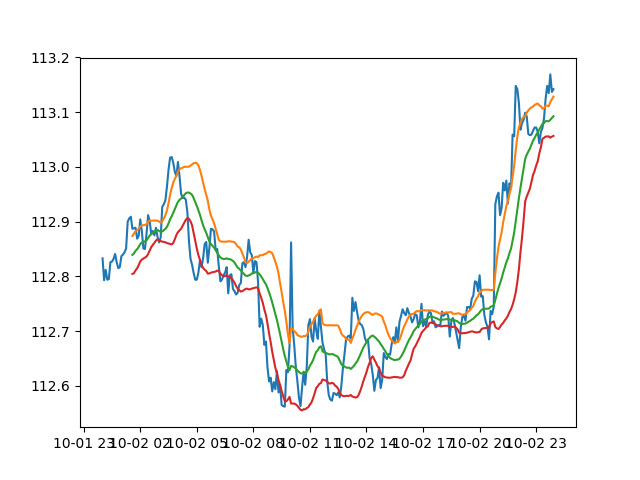

[[<matplotlib.lines.Line2D at 0x7fbe4017be10>],

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
data = hd.data()['Close']
x = data.index
y = data.values
sd = 1
upper, middle, lower = talib.BBANDS(data.values, timeperiod=20, matype=talib.MA_Type.SMA, nbdevup=sd, nbdevdn=sd)
[plt.plot(x, val) for val in [y, upper, middle, lower]]

In [ ]:
data.values

array([ 112.833,  112.793,  112.812,  112.794,  112.795,  112.826,
        112.827,  112.832,  112.841,  112.826,  112.815,  112.817,
        112.837,  112.84 ,  112.844,  112.851,  112.9  ,  112.906,
        112.909,  112.887,  112.888,  112.889,  112.869,  112.874,
        112.904,  112.883,  112.851,  112.85 ,  112.878,  112.912,
        112.901,  112.877,  112.883,  112.875,  112.889,  112.872,
        112.862,  112.871,  112.927,  112.932,  112.939,  112.964,
        112.995,  113.017,  113.018,  113.008,  112.991,  112.983,
        113.009,  112.983,  112.951,  112.943,  112.944,  112.94 ,
        112.917,  112.865,  112.832,  112.821,  112.806,  112.794,
        112.794,  112.807,  112.829,  112.817,  112.833,  112.859,
        112.863,  112.825,  112.852,  112.887,  112.886,  112.882,
        112.848,  112.85 ,  112.818,  112.791,  112.794,  112.802,
        112.807,  112.817,  112.769,  112.802,  112.804,  112.777,
        112.773,  112.767,  112.77 ,  112.784,  112.788,  112.

In [ ]:
logger.info('DeepFX Finished: %s' % DebugTools.now_str())

DeepFX Finished: 17/11/06 01:16:06


## References

- [Deep Q-LearningでFXしてみた](http://recruit.gmo.jp/engineer/jisedai/blog/deep-q-learning/)
- [slide](https://www.slideshare.net/JunichiroKatsuta/deep-qlearningfx)